In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.ndimage import gaussian_filter
from torch.autograd import Variable
from torch.optim import Adam
from inpainter import  SCFEGANInpainter, BlurryInpainter
from mri_model import MriNet
from mri_model import MriData
from nilearn import plotting
import nibabel as nib
from sklearn.metrics import accuracy_score

%matplotlib inline

In [35]:
X, y = np.load('tensosrs.npy'), np.load('labels.npy')
#add dim in X in normal variant
# X = np.squeeze(X)
print(X.shape, y.shape)

(517, 1, 58, 70, 58) (517,)


In [3]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #may be that's bad idea to split using train_test_split. Instead of it - use indexes of data
# train_dataset = MriData(X_train, y_train)
# test_dataset = MriData(X_test, y_test)
dataset = MriData(X,y)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=46, shuffle=True)  #46 - recommended empirical value for batchsize
# val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
loader = torch.utils.data.DataLoader(dataset, batch_size=46, shuffle=False)

In [4]:
# torch.manual_seed(1)
# np.random.seed(1)

# c = 32
# net = MriNet(c).to(device)
# net.load_state_dict(torch.load('./drive/My Drive/5NN/best_model', map_location=device))
# net = net.float()
# net.eval()
# for param in net.parameters():
#     param.requires_grad = False
device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else
torch.manual_seed(1)
np.random.seed(1)
c = 32
net = MriNet(c)
net.load_state_dict(torch.load('C:/Users/maxsk/ML/5NN/best_model'))
net = net.float()
net.to(device)
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [5]:
def get_prediction(net, data_loader):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) # get the index of the max log-probability
        del data, target
    return pred_list

In [6]:
pred = np.concatenate(get_prediction(net,loader),axis=0)

In [10]:
accuracy_score(y,pred)

0.8878143133462283

In [58]:
# def jittering(img,jit) :
#     return np.resize(img,(img.shape[0]+jit,img.shape[1]+jit,img.shape[2]+jit))

In [7]:
def upsample(mask, img_size):
    x = F.interpolate(mask, size=img_size, mode='trilinear', align_corners=False)
    return x

In [84]:
def np_to_torch(X,device,img_size,requires_grad = False):
    output = torch.from_numpy(X).to(device).reshape(img_size)
    return  Variable(output, requires_grad = requires_grad)

In [12]:
def tv_norm(x, beta = 1):
    d1 = torch.mean(torch.abs(x[:,:,:-1,:,:]-x[:,:,1:,:,:]).pow(beta))
    d2 = torch.mean(torch.abs(x[:,:,:,:-1,:]-x[:,:,:,1:,:]).pow(beta))
    d3 = torch.mean(torch.abs(x[:,:,:,:,:-1]-x[:,:,:,:,1:]).pow(beta))
    tv =  d1+d2+d3
    return tv

In [97]:
N, C, D, H, W = X.shape
mask_scale = 4
# mask_size = (5,7,5)
img_change = BlurryInpainter()
blur_sigma_img = 10
max_iter = 300
rw_max = max_iter//5
l1_coeff = 20
tv_coeff = 5
tv_beta = 5
# repetition_general = 3
# img = img/np.max(img)



res = []
for i,img in enumerate(X[:2]):
    
    model_ans = pred[i]
    
    blur_img = gaussian_filter(img, sigma=10)

    mask = torch.ones((1, C, D // mask_scale, H // mask_scale, W // mask_scale)).to(device)
    mask = Variable(mask,requires_grad=True)
    
    optimizer = Adam([mask],0.1, betas=(0.9, 0.99), amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    best_loss, best_mask = float('inf'), None
    for epoch in range(max_iter):
        
        optimizer.zero_grad()
#         total_pred_loss, total_reg_loss = 0, 0
    #     for _ in range(repetition_general):
    #         img = jittering(img,jit)
    #         j0 = np.random.randint(jit)
    #         j1 = np.random.randint(jit)
    #         j2 = np.random.randint(jit)
    #         img_jit = img[j0:(image_size[0]+j0),j1:(image_size[1]+j1),j2:(image_size[2]+j2)]
    #         blur_img_jit = blur_img[j0:(image_size[0]+j0),j1:(image_size[1]+j1),j2:(image_size[2]+j2)]
        img_torch = np_to_torch(img,device,img_size=(1,C,D,H,W))
        
        mask_up = upsample(mask, img_size=(D, H, W))#mask_blur?
    #     blur_torch = img_change.generate_background(img_torch, None)
        blur_torch = np_to_torch(blur_img,device,img_size=(1,C,D,H,W))
        perturbated_input = img_torch.mul(mask_up)+blur_torch.mul(1-mask_up)
        
        outputs = net(perturbated_input.float())
        prob = torch.exp(outputs)
        reg_loss = l1_coeff*torch.mean(torch.abs(1-mask))
        pred_loss = F.relu(prob[0, model_ans] - 0.05)
        reg_loss += tv_coeff * tv_norm(mask_up, tv_beta)
    
        rw = 1 if epoch > rw_max else epoch / rw_max
        loss = pred_loss + rw *reg_loss  
        
        if epoch > 50 and loss.item() <= best_loss:  # 10 in original
            best_loss = loss.item()
            best_mask = mask.clone().detach()
    
        
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)
        mask.data.clamp_(0,1)
    if i%1 == 0:
        print('{} iteration is finished.'.format(i))
    res_mask = upsample((1-best_mask),img_size=(D, H, W))
    res_mask = np.where(res_mask>0.3,1,0)
    res.append(res_mask)
    del mask, optimizer, scheduler, best_loss, best_mask

0 iteration is finished.
1 iteration is finished.


In [98]:
X_mask = np.stack(res,axis=0)
X_mask =  X_mask.squeeze(axis=1)

(1, 1, 58, 70, 58)

In [101]:
dataset_mask = MriData(X_mask*X,y)
loader_mask = torch.utils.data.DataLoader(dataset_mask, batch_size=46, shuffle=False)
pred_mask = np.concatenate(get_prediction(net,loader_mask),axis=0)
accuracy_score(y,pred_mask)

29.0

In [ ]:
a = 0
for i, mask in enumerate(X_mask):
  a += np.count_nonzero(mask*X[i])
total = a / X_mask.shape[0]

In [ ]:
b = 0
for i, mask in enumerate(X):
  b += np.count_nonzero(mask)
total_orig = b / X.shape[0]

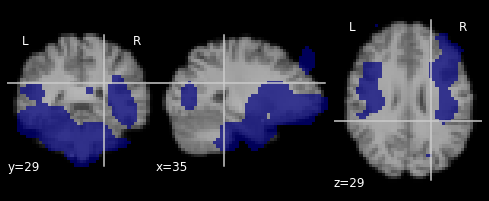

In [102]:

roi_img = nib.Nifti1Image( np.squeeze(res[0]),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(35,29,29))
plotting.show()

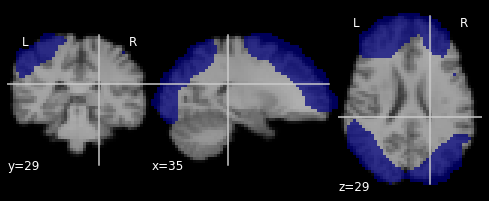

In [103]:

roi_img = nib.Nifti1Image( np.squeeze(res[1]),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(35,29,29))
plotting.show()

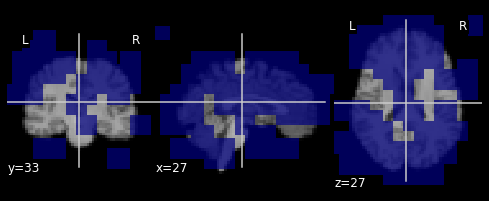

In [83]:
data = np.squeeze(upsample((1-best_mask),img_size=(D, H, W)))
data = np.where(data>0,1,0)
roi_img = nib.Nifti1Image(data,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img)
plotting.show()

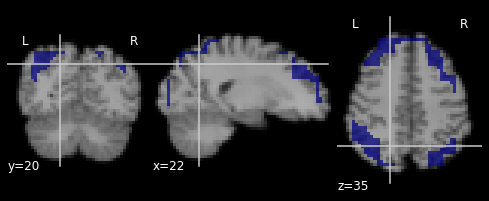

In [80]:


data = np.squeeze(upsample((1-best_mask),img_size=(D, H, W)))
data = np.where(data>0.9,1,0)
roi_img = nib.Nifti1Image(data,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img)
plotting.show()

In [45]:
best_mask.min()

tensor(0.)

In [47]:
best_mask.max()

tensor(1.)

In [46]:
best_mask.shape

torch.Size([1, 1, 14, 17, 14])

In [81]:
torch.exp(net( (np_to_torch(X[1],device)).mul(np_to_torch(data,device))))

tensor([[0.0679, 0.9321]])

In [48]:
best_mask

tensor([[[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000

In [ ]:
# jit = 4
# blur_img = gaussian_filter(img, sigma=15)
# img = jittering(img,jit)
#     j0 = np.random.randint(jit)
#     j1 = np.random.randint(jit)
#     j2 = np.random.randint(jit)
#     img_jit = img[j0:(image_size[0]+j0),j1:(image_size[1]+j1),j2:(image_size[2]+j2)]
#     blur_img_jit = blur_img[j0:(image_size[0]+j0),j1:(image_size[1]+j1),j2:(image_size[2]+j2)]
    
#     mask_blur = gaussian_filter(mask,sigma=2)
#     blur_torch = np_to_torch(blur_img,device)
    upsample_mask = nn.Upsample(image_size,mode='nearest')(mask.reshape(1,1,5,7,5))

In [19]:
(1-best_mask)

tensor([[[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 5.9873e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [7.7486e-07, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],

          [[6.4907e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [7.7486e-07, 2.7704e-01, 8.3974e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 3.7

In [4]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()